# GeoPandas: Advanced topics

## 1. Introduction

We covered the basics of GeoPandas in the previous episode and notebook. Here, we'll extend that introduction to illustrate additional aspects of GeoPandas and its interactions with other Python libraries, covering fancier mapping, analysis (unitary and binary spatial operators), raster zonal stats + GeoPandas. 

**Here are the main sections in this episode / notebook:**
- Read HydroBASINS Pacific NW / Western Washington from a shape file.
- Dissolve into larger watersheds, and reproject
- Plot `choropleth` map based on calculated watershed areas
- Choropleth map as an interactive map with folium
- Spatial join, `sjoin`, of polygons on points
- rasterstats: "zonal" statistics from polygons on rasters

## 2. Set up packages and data file path
We'll use these throughout the rest of the tutorial.

In [1]:
%matplotlib inline

from __future__ import (absolute_import, division, print_function)
import os
import json
import psycopg2

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

data_pth = "../data"

In [2]:
mpl.__version__, pd.__version__, gpd.__version__

('2.2.3', '0.23.4', '0.4.0')

In [3]:
with open(os.path.join(data_pth, "db.json")) as f:
    db_conn_dict = json.load(f)

## 3. Read HydroBASINS North America / Western Washington
Read [HydroBASINS](http://hydrosheds.org/page/hydrobasins) "all-levels" (lev00) hierarchical watersheds dataset for the Pacific NW, from Amazon Cloud PostgreSQL/PostGIS database. **Watersheds in the dataset are at the finest (highest resolution) "Pfastetter" hierarchical level, level 12.**

`read_postgis` is called as before, except now we'll apply a SQL filter (server side) to the PostGIS dataset to select only the Pfastetter level-4 watershed with code 7831: `WHERE pfaf_4 = 7831`. This is **most of Western Washington.** Watershed polygons will still be read at their original level 12 resolution.

In [4]:
conn = psycopg2.connect(**db_conn_dict)

In [5]:
hydrobas_ww = gpd.read_postgis(
    "SELECT * FROM hybas_na_lev00_v1c WHERE pfaf_4 = 7831", conn, 
    geom_col='polygongeom',
    coerce_float=False)

In [6]:
conn.close()

In [7]:
hydrobas_ww.crs

{'init': 'epsg:4326'}

In [8]:
len(hydrobas_ww)

413

413 polygon features returned. Let's examine the attributes for the first feature.

In [9]:
hydrobas_ww.iloc[0]

gid                                                        19945
hybas_id                                             7.00001e+09
next_down                                                      0
next_sink                                            7.00001e+09
main_bas                                             7.00001e+09
dist_sink                                                      0
dist_main                                                      0
sub_area                                                   135.4
up_area                                                    135.4
endo                                                           0
coast                                                          0
order                                                          1
sort                                                       19945
pfaf_1                                                         7
pfaf_2                                                        78
pfaf_3                   

**Plot a categorical map with coloring based on the aggregating column `pfaf_7`.** Watershed *boundaries* are at the high-resolution Pfastetter level 12.

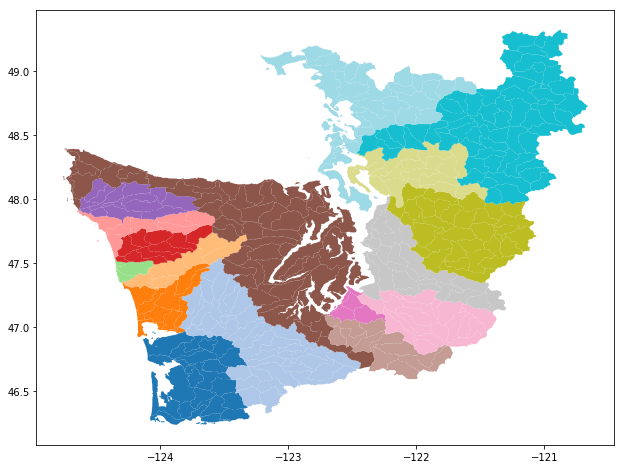

In [10]:
hydrobas_ww.plot(column='pfaf_7', cmap='tab20', categorical=True, figsize=(14, 8));

## 4. Dissolve into larger watersheds, and reproject

### Dissolve source polygons into larger watersheds based on attribute values
Apply GeoDataFrame [dissolve](http://geopandas.org/aggregation_with_dissolve.html) aggregation method (implemented from lower level `shapely` operators) on level-7 Pfastetter codes (`pfaf_7`) shown in the plot above. Aggregate attributes, retaining only `pfaf_7` and `pfaf_6` (plus `polygongeom`, of course). This operation results in only 17 polygons, from the original 413.

In [11]:
cols = ['pfaf_6', 'pfaf_7', 'polygongeom']
hydrobas_ww_p7 = hydrobas_ww[cols].dissolve(by='pfaf_7', aggfunc='first', as_index=False)
len(hydrobas_ww_p7)

17

Let's examine some of the features.

In [12]:
hydrobas_ww_p7.head()

,pfaf_7,polygongeom,pfaf_6
0,7831010,(POLYGON ((-123.4666666666666 46.2666666666666...,783101
1,7831020,POLYGON ((-123.1791666666666 46.33333333333336...,783102
2,7831031,(POLYGON ((-123.9597222222222 46.9666666666667...,783103
3,7831032,POLYGON ((-123.8583333333333 47.39583333333336...,783103
4,7831033,"POLYGON ((-124.3 47.34583333333336, -124.30221...",783103


Plot the results. Looks like the previous plot, except the polygon boundaries are now the pfaf_7 watersheds (same as the background colors).

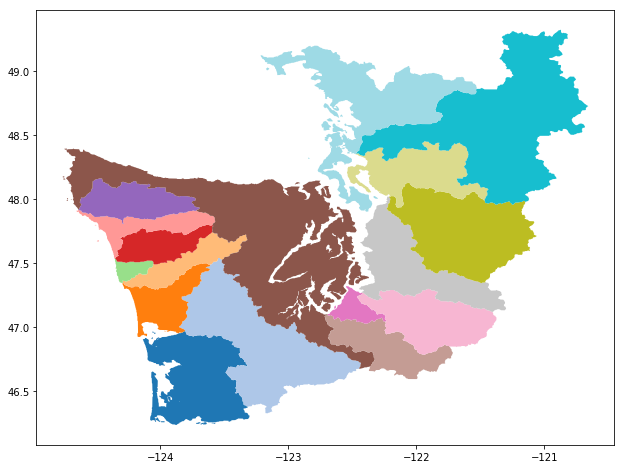

In [13]:
hydrobas_ww_p7.plot(column='pfaf_7', cmap='tab20', categorical=True, figsize=(14, 8));
# original (2017) cmap: 'Paired'

**_NOTE/WATCH:_**   
**Beware that `dissolve` may fail if there are "invalid" geometries.**
This code is based on a GeoDataFrame examined in the previous, intro notebook. The 6 geometries/points reported are invalid (and are reported by the `is_valid()` method). This dissolve statement does work, though.
```python
seas_grp = seas[['oceans', 'geometry']]
seas_oceans_diss = seas_grp[seas_grp.geometry.is_valid].dissolve(by='oceans')

Ring Self-intersection at or near point 10.407218181818182 54.821390909090908
Self-intersection at or near point -79.365827272727287 76.296645454545455
Ring Self-intersection at or near point 10.979445510225332 54.380555030408686
Ring Self-intersection at or near point 133.61550925464189 -4.3005540903175188
Ring Self-intersection at or near point 121.91067196634913 -5.0593090510592447
Ring Self-intersection at or near point 115.29553592754269 -7.0082630551828515
```

### Reproject (transform) to WA State Plane South, epsg:2927
Partly so we can calculate polygon areas in linear units, not geodetic degrees. But also because that's the projection used by most state and local governments in Washington.
- http://epsg.io/?q=2927
- http://spatialreference.org/ref/epsg/2927/
- [Report from http://www.epsg-registry.org](http://www.epsg-registry.org/report.htm?type=selection&entity=urn:ogc:def:crs:EPSG::2927&reportDetail=short&style=urn:uuid:report-style:default-with-code&style_name=OGP%20Default%20With%20Code&title=EPSG:2927)

No need to go to a web site to learn more about what `epsg:2927` is. Use `pyepsg`, which issues queries to http://epsg.io web services.

In [14]:
import pyepsg

Extract the epsg code from the string returned by `crs['init']`, then query epsg `2927`.

In [15]:
hydrobas_ww_p7_epsg_str = hydrobas_ww_p7.crs['init'].split(':')[1]
pyepsg.get(hydrobas_ww_p7_epsg_str)

<GeodeticCRS: 4326, WGS 84>

In [16]:
pyepsg.get('2927')

<ProjectedCRS: 2927, NAD83(HARN) / Washington South (ftUS)>

**Apply the crs transformation (reprojection)** using `to_crs` method.

In [17]:
hydrobas_ww_p7_wasp = hydrobas_ww_p7.to_crs(epsg=2927)

**Plot the reprojected map.** Note that, being in a planar project (not geodetic), the shape looks different compared to the previous map. More "normal". And the axes are now in `feet` relative to some origin.

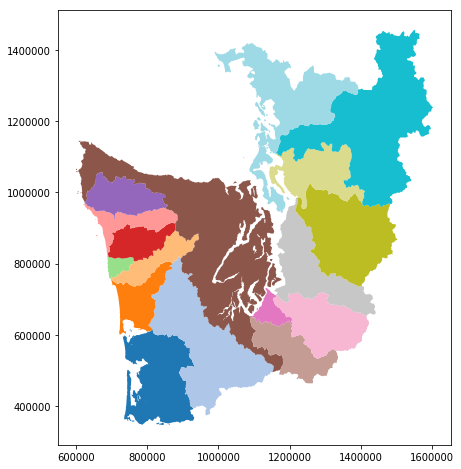

In [18]:
hydrobas_ww_p7_wasp.plot(column='pfaf_7', cmap='tab20', categorical=True, figsize=(14, 8));

## 5. Plot `choropleth` map based on calculated watershed areas
As the projection is in `feet`, auto-calculated polygon areas will be in feet<sup>2</sup>. So let's convert to miles<sup>2</sup> first (why not!). We'll add a new column to the GeoDataFrame.

In [19]:
hydrobas_ww_p7_wasp['area_mi2'] = hydrobas_ww_p7_wasp.geometry.area / 27878400
hydrobas_ww_p7_wasp.head(3)

,pfaf_7,polygongeom,pfaf_6,area_mi2
0,7831010,(POLYGON ((890315.2572612347 354459.8899780738...,783101,1375.137396
1,7831020,"POLYGON ((963803.8027083561 376154.9965688475,...",783102,2107.945774
2,7831031,"(POLYGON ((776917.1877152125 614568.383332147,...",783103,528.472846


**_NOTE/FUN:_**  
Now you could get the area of a pfaf_6 watershed via simple Pandas DataFrame `groupby` aggregation (sum).

Plot the choloropleth, using `area_mi2`.

The "fisher_jenks" value segmentation `scheme` (using 7 segments, k=7) used is one of the available `pysal.esda.mapclassify.Map_Classifier` classifiers from the powerful [PySAL package](http://pysal.github.io) (Python Spatial Analysis Library); GeoPandas can use these classifiers if PySAL is installed, as it is here. To get the list of classifiers, use:
```python
import pysal
print(pysal.esda.mapclassify.Map_Classifier.__doc__)
```

/home/mayorga/miniconda/envs/vectoernv_ghw18/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


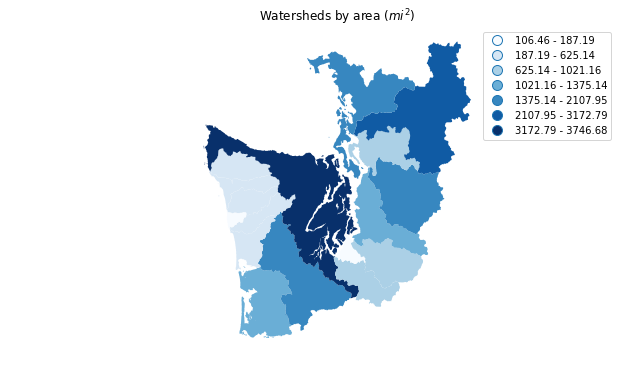

In [20]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Watersheds by area ($mi^2$)')
hydrobas_ww_p7_wasp.plot(column='area_mi2', scheme='fisher_jenks', k=7, 
                         cmap=plt.cm.Blues, legend=True, ax=ax)
ax.set_axis_off()
plt.axis('equal');

## 6. Choropleth map as an interactive map with folium
[Folium](https://github.com/python-visualization/folium) is very cool, specially for use in Jupyter notebooks; or to export into stand-alone HTML.

In [21]:
import folium

In [22]:
folium.__version__

'0.6.0'

`m.choropleth` internally splits the geometry from the other attributes in `hydrobas_ww_p7_wasp`, and rejoins them based on the key `pfaf_7`. `key_on` uses an attribute reference derived from GeoJSON representations; this is awkward, and hopefully will be simplified in future folium implementations.

In [23]:
m = folium.Map(location=[47.8, -122.5], zoom_start=7, tiles="cartodbpositron")

m.choropleth(
    geo_data=hydrobas_ww_p7_wasp,
    data=hydrobas_ww_p7_wasp,
    columns=['pfaf_7', 'area_mi2'],
    key_on='feature.properties.pfaf_7',
    legend_name='Area (sq mi)', 
    fill_color='YlGn',
    fill_opacity=0.4,
    highlight=True)

m

ValueError: Unhandled object      pfaf_7                                        polygongeom  pfaf_6  \
0   7831010  (POLYGON ((890315.2572612347 354459.8899780738...  783101   
1   7831020  POLYGON ((963803.8027083561 376154.9965688475,...  783102   
2   7831031  (POLYGON ((776917.1877152125 614568.383332147,...  783103   
3   7831032  POLYGON ((808869.5755557655 769864.5311527567,...  783103   
4   7831033  POLYGON ((698711.1808079176 756609.8674803674,...  783103   
5   7831034  POLYGON ((710751.1671345124 813853.6709028682,...  783103   
6   7831035  (POLYGON ((659983.8892144207 877220.0078871435...  783103   
7   7831036  POLYGON ((836230.8470860495 955842.450039029, ...  783103   
8   7831037  (POLYGON ((1152070.420377198 496802.1299301988...  783103   
9   7831038  POLYGON ((1263367.932787178 463973.6240853097,...  783103   
10  7831039  (POLYGON ((1094694.768557548 653358.3519652043...  783103   
11  7831040  POLYGON ((1344328.067030076 553780.7185956305,...  783104   
12  7831050  POLYGON ((1162563.712240118 712396.514769426, ...  783105   
13  7831060  POLYGON ((1459365.247366856 815317.2869431507,...  783106   
14  7831070  POLYGON ((1176137.138746991 1060277.614108794,...  783107   
15  7831080  POLYGON ((1215375.262918341 1088268.438716016,...  783108   
16  7831090  (POLYGON ((1199352.043088766 979126.9852467919...  783109   

       area_mi2  
0   1375.137396  
1   2107.945774  
2    528.472846  
3    441.528065  
4    106.456891  
5    454.667320  
6    413.540327  
7    625.143976  
8   3746.681306  
9    727.179334  
10   187.192361  
11  1021.155731  
12  1194.685518  
13  1755.366812  
14   911.638846  
15  3172.794221  
16  1747.922096  .

This map is interactive, so play with it (zoom and pan). There is a lot more to explore in Folium! This is just a teaser.

## 7. Spatial join, `sjoin`, of polygons on points
We'll use an old, local snapshot of NANOOS coastal and marine monitoring stations in the Pacific NW, from the [NANOOS Visualization System (NVS) Data Explorer](http://nvs.nanoos.org/Explorer). While many stations are moorings on marine waters, some are inshore or in tidal shores and will overlap the watershed boundaries. The point file is in the [GeoPackage](http://www.geopackage.org) format, an OGC format implemented in SQLite.

In [ ]:
nanoosstations_gdf = gpd.read_file(os.path.join(data_pth, "nanoos_nvs.gpkg"))
len(nanoosstations_gdf)

In [ ]:
nanoosstations_gdf.iloc[-1]

Points are on the coasts of the Pacific NW (BC, WA, OR) and out in the open ocean.

In [ ]:
nanoosstations_gdf.plot(markersize=15);

**Apply "inner" spatial join with `sjoin` operator** from the `gpd.tools` package. An inner join will retain only overlapping features. Then plot as a map overlay on top of `hydrobas_ww_p7`, categorizing (coloring) each point by the `pfaf_6` watershed it's in.

In [ ]:
nanoossta_hydrobas_ww_gdf = gpd.tools.sjoin(nanoosstations_gdf, hydrobas_ww_p7, how="inner")
len(nanoossta_hydrobas_ww_gdf)

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_axis_off()
plt.axis('equal')
hydrobas_ww_p7.plot(ax=ax, cmap='Greys_r', linewidth=1)
nanoossta_hydrobas_ww_gdf.plot(column='pfaf_6', markersize=30, 
                               categorical=True, legend=True, ax=ax);

## 8. rasterstats: "zonal" statistics from polygons on rasters
We'll end by mixing features from a GeoDataFrame with a raster, applying zonal statistics using the cool and light weight [rasterstats](https://github.com/perrygeo/python-rasterstats) package.

Monthly Juy long-term climatology precipitation. The original monthly time series data are from the [PRISM Climate Group](http://prism.oregonstate.edu); the monthly climatology and Pacific NW clip were created by your truly and Don Setiawan for the [BiGCZ project](http://bigcz.org).

In [ ]:
ppt_july_tif_pth = os.path.join(data_pth, 'prism_precipitation_july_climatology.tif')

### rasterio

Rasterstas uses [rasterio](https://mapbox.github.io/rasterio) to read rasters (and `fiona` to read vector datasets), so we'll first do a quick exploration of rasterio.

In [ ]:
import rasterio
import rasterio.plot as rioplot

In [ ]:
rasterio.__version__

In [ ]:
ppt_july = rasterio.open(ppt_july_tif_pth)
ppt_july

Examine the metadata read from the raster file (we can confirm CRS is epsg:4326), then plot the raster. 

In [ ]:
ppt_july.meta

**_NOTE/WATCH:_**  
`with_bounds=True` is supposed to display the X & Y coordinate labels (lat & lon) from the metadata. We don't know why this isn't working.

In [ ]:
rioplot.show(ppt_july, with_bounds=True, cmap=plt.cm.Blues);

### Apply rasterstas `zonal_stats`

Apply `zonal_stats` from `rasterstats` package. Can pass a `GeoDataFrame` directly (instead of the file path to a GIS file) because it implements our old friend, the `__geo_interface__` method. For the raster, we pass its file path.

`zonal_stats` returns a geojson with the original properties plus the zonal statistics.

In [ ]:
import rasterstats as rs

In [ ]:
rs.__version__

Unfortunately, `rasterstats` requires the geometry column to be named "geometry". So, we'll rename it first.

In [ ]:
hydrobas_ww_p7 = hydrobas_ww_p7.rename(columns={'polygongeom': 'geometry'})
hydrobas_ww_p7._geometry_column_name = 'geometry'

In [ ]:
zonal_ppt_gjson = rs.zonal_stats(hydrobas_ww_p7, ppt_july_tif_pth, prefix='pptjuly_',
                                 geojson_out=True)

In [ ]:
type(zonal_ppt_gjson), len(zonal_ppt_gjson)

In [ ]:
zonal_ppt_gdf = GeoDataFrame.from_features(zonal_ppt_gjson)
zonal_ppt_gdf.head(2)

#### And finally, a choropleth map of July precipitation by watershed!

In [ ]:
f, ax = plt.subplots(1, figsize=(8, 6))
ax.set_title('Mean July precipitation ($mm/month$) by watershed')
zonal_ppt_gdf.plot(column='pptjuly_mean', scheme='Equal_Interval', k=5, 
                   cmap=plt.cm.Blues, legend=True, linewidth=1, ax=ax)
plt.axis('equal');